#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

## Подготовка

Загрузим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

Импортируем данные:

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

Изучим данные:

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Данные содержат две колонки: промежуток времени и количество заказов, сделанных в этот промежуток. Промежуток - 10 минут.

Проверим данные на на наличие дубликатов и пропусков:

In [5]:
data.duplicated().sum()

26415

In [6]:
data.isna().sum()

num_orders    0
dtype: int64

Дубликатов и пропусков нет.

Так как необходимо будем предсказывать количество заказов на следующий час, выполним ресемплирование данных по одному часу:

In [7]:
data = data.resample('1H').sum()

In [8]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Теперь количество заказов в датасете указано за каждый час. Данные готовы к работе.

## Анализ

Проанализируем данные:

In [9]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


<AxesSubplot:xlabel='datetime'>

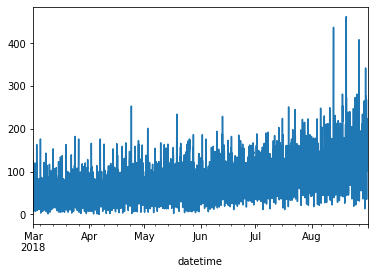

In [10]:
data['num_orders'].plot()

В датасете представлены данные о поездках с марта по август 2018 года. Среднее число поездок в час - 84, минимальное - 0, максимальное - 462. Разброс достаточно большой. На графике видно, что среднее число поездок растет с марта по август. Тот факт, что с июля по август число поездок также растет, не позволяет сделать вывод о сезонной популярности такси в летнее время. Скорее всего, этот рост связан с ростом популярности самой компании.

Проверим данные на тренды и сезонность:

In [11]:
decomposed = seasonal_decompose(data)

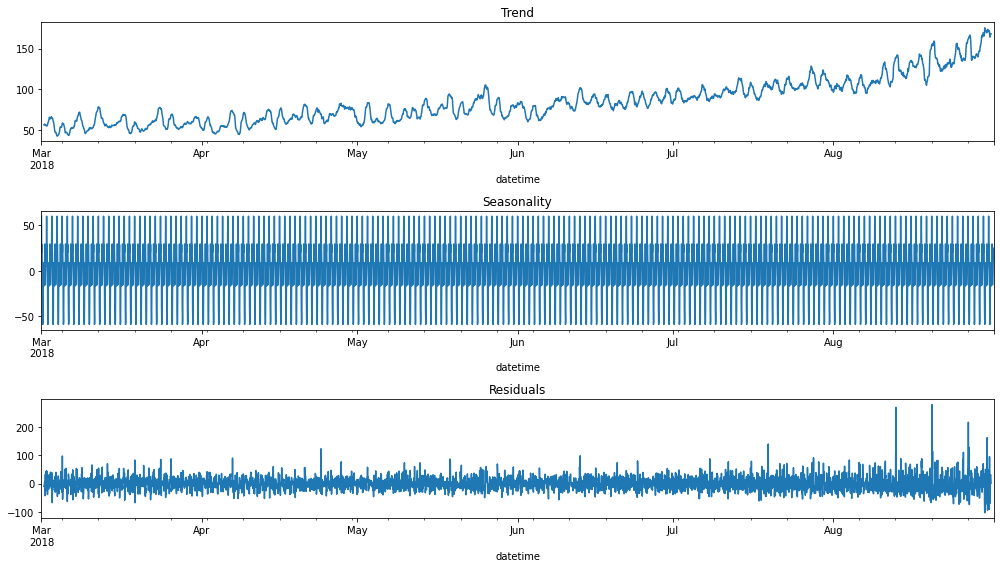

In [12]:
plt.figure(figsize=(14, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Данный анализ позволяет выделить только один тренд - стабильное увеличение числа заказов с марта по август. Так как имеются данные только за пол года, выявить какие-либо сезонные особенности не представляется возможным. Посмотрим, как меняется число заказов в течение одного месяца:

<AxesSubplot:xlabel='datetime'>

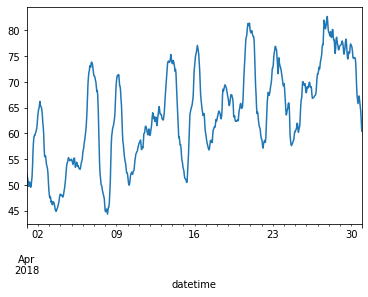

In [13]:
decomposed.trend['2018-04-01':'2018-04-30'].plot()

График за месяц очень нестабильный. Можно сделать вывод, что число заказов сильно зависит от времени суток. Посмотрим на график числа заказов в течение одних суток:

<AxesSubplot:xlabel='datetime'>

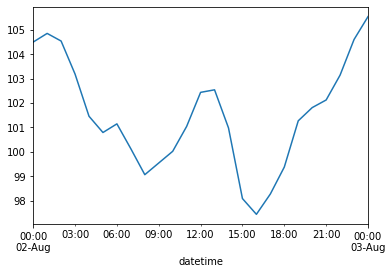

In [14]:
decomposed.trend['2018-08-02 00:00:00':'2018-08-03 00:00:00'].plot()

<AxesSubplot:xlabel='datetime'>

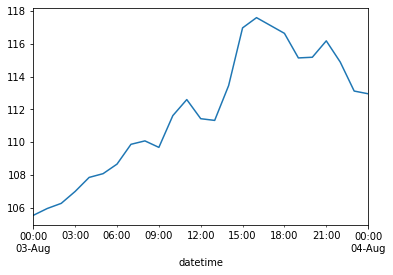

In [15]:
decomposed.trend['2018-08-03 00:00:00':'2018-08-04 00:00:00'].plot()

<AxesSubplot:xlabel='datetime'>

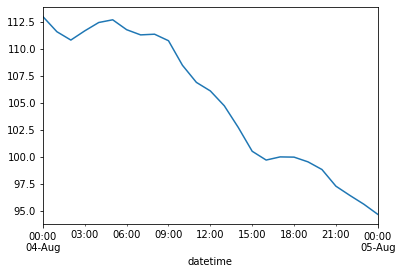

In [16]:
decomposed.trend['2018-08-04 00:00:00':'2018-08-05 00:00:00'].plot()

Графики за несколько соседних суток доказывают, что количество поездок сильно варьируется в течение одного дня. Однако, данные графики сильно отличаются, что говорит о том, что невозможно выделить наиболее и наименее популярное для поездок на такси время суток.

Таким образом, предоставленные данные демонстрируют значительный рост популярности сервиса в течение 6 месяцев. Однако, по предоставленным данным невозможно отследить какие-либо сезонные тренды или выделить наиболее популярное для заказа время суток.

## Обучение

Построим модель для прогнозирования количества заказов такси на следующий час. Для этого создадим дополнительные признаки для модели: месяц, число, день недели, час, отстающие значения и скользящее среднее.

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 10, 24)

In [20]:
data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Признаки готовы. Разделим данные на обучающую и тестовую выборки, удалим пропуски, выделим признаки и целевой признак:

In [21]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [22]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(3950, 13)
(3950,)
(442, 13)
(442,)


Данные готовы для обучения моделей.

В качестве метрики будем использовать rmse. Создадим соответствующую функцию и scorer для кросс-валидации.

In [23]:
def rmse(target, predicted):
    mse = mean_squared_error(target, predicted)
    return mse**0.5
rmse_scorer = make_scorer(rmse, greater_is_better=False)

**Создадим модель линейной регрессии:**

In [24]:
LR = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)
score = cross_val_score(LR, features_train, target_train, scoring=rmse_scorer, cv=tscv).mean()
print('rmse модели:', score)

rmse модели: -31.610350570725537


Модель линейной регресси показала результат rmse - 31.6.

**Создадим модель древа решений и подберем наилучшие параметры:**

In [25]:
DTR = DecisionTreeRegressor(random_state=12345)
GSCV = GridSearchCV(DTR, {'max_depth': list(range(1, 10))}, cv=tscv, scoring=rmse_scorer)
GSCV.fit(features_train, target_train)
print('Лучшая глубина древа:', GSCV.best_estimator_)
print('rmse модели:', GSCV.best_score_)

Лучшая глубина древа: DecisionTreeRegressor(max_depth=7, random_state=12345)
rmse модели: -29.70819347355241


Лучшая глубина древа для модели древа решений - 7, rmse такой модели - 29.7.

**Создадим модель случайного леса и подберем наилучшие параметры:**

In [26]:
RFR = RandomForestRegressor(random_state=12345)
RSCV = RandomizedSearchCV(RFR, {'max_depth': list(range(1, 20)), 'n_estimators': list(range(1, 20))}, cv=tscv, scoring=rmse_scorer)
RSCV.fit(features_train, target_train)
print('Лучшие параметры случайного леса:', RSCV.best_params_)
print('rmse модели:', RSCV.best_score_)

Лучшие параметры случайного леса: {'n_estimators': 16, 'max_depth': 16}
rmse модели: -26.165895012894016


Лучшие параметры для случайного леса: количество деревьев - 14, максимальная глубина древа - 9. Rmse такой модели - 26.6.

**Создадим модель градиентного бустинга:**

In [27]:
gbm = lgb.LGBMRegressor(objective='regression')
score = cross_val_score(gbm, features_train, target_train, scoring=rmse_scorer, cv=tscv).mean()
print('rmse модели:', score)

rmse модели: -25.312778225811297


Модель градиентного бустинга показала результат rmse 25.3.

## Тестирование

Наилучшие результат показали модели случайного леса и градиентного бустинга. Проверим данные модели на тестовой выборке, также сравним время обучения и предсказания данных моделей:

*Модель случайного леса:*

In [28]:
%%time
RFR = RandomForestRegressor(random_state=12345, n_estimators=14, max_depth=9)
RFR.fit(features_train, target_train)

CPU times: user 256 ms, sys: 4.02 ms, total: 260 ms
Wall time: 267 ms


RandomForestRegressor(max_depth=9, n_estimators=14, random_state=12345)

In [29]:
%%time
rfr_predicted = RFR.predict(features_test)

CPU times: user 6.89 ms, sys: 0 ns, total: 6.89 ms
Wall time: 5.06 ms


In [30]:
'rmse:', rmse(target_test, rfr_predicted)

('rmse:', 45.929050955133434)

*Модель градиентного бустинга:*

In [31]:
%%time
gbm.fit(features_train, target_train)

CPU times: user 55.8 s, sys: 164 ms, total: 56 s
Wall time: 56.1 s


LGBMRegressor(objective='regression')

In [32]:
%%time
gbm_predicted = gbm.predict(features_test)

CPU times: user 86.2 ms, sys: 0 ns, total: 86.2 ms
Wall time: 95.5 ms


In [33]:
'rmse:', rmse(target_test, gbm_predicted)

('rmse:', 43.729007371822476)

**Наилучший результат показала модель градиентного бустинга - 43.7.**